# HIPS vs Aethalometer Optical Comparison

## Research Question
How do two independent optical absorption measurements compare?

## Why This Comparison Matters

Both HIPS and Aethalometer measure **light absorption by particles**, but using different methods:

| Method | What it Measures | Wavelength | Sample Type |
|--------|-----------------|------------|-------------|
| **HIPS** | Filter absorption (Fabs) | 405 nm (UV-like) | Integrated filter sample |
| **Aethalometer ATN** | Raw attenuation | 375-880 nm | Real-time on filter tape |
| **Aethalometer BCc** | Processed BC concentration | 375-880 nm | Algorithm-compensated |

## Key Questions

1. **Does HIPS correlate better with raw ATN or processed BCc?**
   - If better with ATN: Processing may be adding artifacts
   - If better with BCc: Processing improves accuracy

2. **Which aethalometer wavelength best matches HIPS?**
   - HIPS uses ~405 nm, so UV (375 nm) or Blue (470 nm) should match best

3. **Is the HIPS-Aethalometer relationship consistent across sites?**

## 1. Setup and Imports

In [46]:
import sys
sys.path.insert(0, './scripts')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from pathlib import Path
from scipy import stats as scipy_stats  # Renamed to avoid shadowing by loop variables

# Configure matplotlib
plt.style.use('seaborn-v0_8-whitegrid')
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 10)
plt.rcParams['font.size'] = 11

print("Setup complete!")

Setup complete!


## 2. Configuration

In [47]:
# Site configuration
SITES = {
    'Beijing': {
        'file': 'processed_sites/df_Beijing_9am_resampled.pkl',
        'code': 'CHTS',
        'color': '#E41A1C'
    },
    'Delhi': {
        'file': 'processed_sites/df_Delhi_9am_resampled.pkl',
        'code': 'INDH',
        'color': '#377EB8'
    },
    'JPL': {
        'file': 'processed_sites/df_JPL_9am_resampled.pkl',
        'code': 'USPA',
        'color': '#4DAF4A'
    },
    'Addis Ababa': {
        'file': 'processed_sites/df_Addis_Ababa_9am_resampled.pkl',
        'code': 'ETAD',
        'color': '#984EA3'
    }
}

# Wavelengths
WAVELENGTHS = ['UV', 'Blue', 'Green', 'Red', 'IR']

# HIPS uses ~405 nm wavelength
HIPS_WAVELENGTH_NM = 405

# Mass Absorption Cross-section for converting Fabs to BC equivalent
MAC_VALUE = 10.0  # m²/g

print("Configuration loaded.")
print(f"HIPS wavelength: {HIPS_WAVELENGTH_NM} nm")
print(f"MAC value: {MAC_VALUE} m²/g")

Configuration loaded.
HIPS wavelength: 405 nm
MAC value: 10.0 m²/g


## 3. Load Data

In [48]:
def match_hips_with_aethalometer(site_name, df_aeth, filter_data, site_code, 
                                  date_tolerance_days=1):
    """
    Match HIPS Fabs with aethalometer data (both ATN and BCc).
    
    Parameters:
    -----------
    site_name : str
    df_aeth : DataFrame with aethalometer data
    filter_data : DataFrame with filter data
    site_code : str (e.g., 'CHTS', 'ETAD')
    date_tolerance_days : int
    
    Returns:
    --------
    DataFrame with matched HIPS and aethalometer values
    """
    # Get HIPS data for this site
    site_hips = filter_data[
        (filter_data['Site'] == site_code) &
        (filter_data['Parameter'] == 'HIPS_Fabs')
    ].copy()
    
    if len(site_hips) == 0:
        print(f"  {site_name}: No HIPS data")
        return None
    
    # Ensure day_9am is datetime (handle both date and datetime)
    df_aeth = df_aeth.copy()
    df_aeth['day_9am'] = pd.to_datetime(df_aeth['day_9am'])
    
    # Find available aethalometer columns
    atn_cols = {wl: f'{wl} ATN1' for wl in WAVELENGTHS if f'{wl} ATN1' in df_aeth.columns}
    bcc_cols = {wl: f'{wl} BCc' for wl in WAVELENGTHS if f'{wl} BCc' in df_aeth.columns}
    
    matched_records = []
    
    for _, hips_row in site_hips.iterrows():
        hips_date = pd.to_datetime(hips_row['SampleDate'])  # Ensure it's a Timestamp
        hips_fabs = hips_row['Concentration']  # Mm⁻¹
        
        # Find matching aethalometer data
        date_match = df_aeth[
            (df_aeth['day_9am'] >= hips_date - pd.Timedelta(days=date_tolerance_days)) &
            (df_aeth['day_9am'] <= hips_date + pd.Timedelta(days=date_tolerance_days))
        ]
        
        if len(date_match) == 0:
            continue
        
        record = {
            'date': hips_date,
            'hips_fabs': hips_fabs,  # Mm⁻¹
            'hips_bc_equiv': hips_fabs / MAC_VALUE,  # µg/m³ equivalent
            'filter_id': hips_row.get('FilterId', 'unknown')
        }
        
        # Add ATN values
        for wl, col in atn_cols.items():
            if date_match[col].notna().any():
                record[f'{wl}_ATN'] = date_match[col].mean()
        
        # Add BCc values (convert ng/m³ to µg/m³)
        for wl, col in bcc_cols.items():
            if date_match[col].notna().any():
                record[f'{wl}_BCc'] = date_match[col].mean() / 1000  # ng to µg
        
        matched_records.append(record)
    
    if len(matched_records) == 0:
        print(f"  {site_name}: No matched data")
        return None
    
    return pd.DataFrame(matched_records)


def calculate_regression(x, y):
    """
    Calculate linear regression statistics.
    
    Returns dict with n, slope, intercept, r_squared, p_value
    """
    # Remove NaN
    mask = (~np.isnan(x)) & (~np.isnan(y))
    x_clean = x[mask]
    y_clean = y[mask]
    
    if len(x_clean) < 3:
        return None
    
    slope, intercept, r_value, p_value, std_err = scipy_stats.linregress(x_clean, y_clean)
    
    return {
        'n': len(x_clean),
        'slope': slope,
        'intercept': intercept,
        'r_squared': r_value**2,
        'r': r_value,
        'p_value': p_value,
        'std_err': std_err
    }


def plot_comparison(ax, x_data, y_data, x_label, y_label, color, title=None):
    """
    Create scatter plot with regression line.
    """
    x_arr = np.asarray(x_data)
    y_arr = np.asarray(y_data)
    
    # Remove NaN
    mask = (~np.isnan(x_arr)) & (~np.isnan(y_arr))
    x_clean = x_arr[mask]
    y_clean = y_arr[mask]
    
    if len(x_clean) < 3:
        ax.text(0.5, 0.5, 'Insufficient data', ha='center', va='center', fontsize=12)
        ax.set_xlabel(x_label)
        ax.set_ylabel(y_label)
        if title:
            ax.set_title(title)
        return None
    
    # Scatter plot
    ax.scatter(x_clean, y_clean, color=color, alpha=0.6, s=80,
               edgecolors='black', linewidth=0.5)
    
    # Calculate regression
    reg_stats = calculate_regression(x_clean, y_clean)
    
    if reg_stats:
        # Regression line
        x_line = np.array([0, x_clean.max() * 1.1])
        y_line = reg_stats['slope'] * x_line + reg_stats['intercept']
        ax.plot(x_line, y_line, 'g-', linewidth=2, alpha=0.8, label='Best fit')
        
        # 1:1 line (if applicable)
        max_val = max(x_clean.max(), y_clean.max()) * 1.1
        ax.plot([0, max_val], [0, max_val], 'k--', alpha=0.5, linewidth=1.5, label='1:1 line')
        
        # Stats text
        sign = '+' if reg_stats['intercept'] >= 0 else '-'
        eq = f"y = {reg_stats['slope']:.3f}x {sign} {abs(reg_stats['intercept']):.2f}"
        text = f"n = {reg_stats['n']}\nR² = {reg_stats['r_squared']:.3f}\n{eq}"
        ax.text(0.05, 0.95, text, transform=ax.transAxes, fontsize=10,
                verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.9))
    
    ax.set_xlim(left=0)
    ax.set_ylim(bottom=0)
    ax.set_xlabel(x_label, fontsize=11)
    ax.set_ylabel(y_label, fontsize=11)
    ax.legend(loc='lower right', fontsize=9)
    ax.grid(True, alpha=0.3)
    
    if title:
        ax.set_title(title, fontsize=12, fontweight='bold')
    
    return reg_stats

print("Helper functions defined.")

Helper functions defined.


In [49]:
# Load filter data (contains HIPS)
filter_path = Path('Filter Data/unified_filter_dataset.pkl')

if filter_path.exists():
    with open(filter_path, 'rb') as f:
        filter_data = pickle.load(f)
    filter_data['SampleDate'] = pd.to_datetime(filter_data['SampleDate'])
    print(f"Filter data loaded: {len(filter_data)} records")
    print(f"Parameters: {filter_data['Parameter'].unique()}")
    print(f"Sites: {filter_data['Site'].unique()}")
else:
    print(f"Filter data not found at {filter_path}")

Filter data loaded: 44493 records
Parameters: ['ChemSpec_Ammonium_Ion_PM2.5' 'ChemSpec_Bromide_Ion_PM2.5'
 'ChemSpec_Calcium_Ion_PM2.5' 'ChemSpec_Filter_PM2.5_mass'
 'ChemSpec_Magnesium_Ion_PM2.5' 'ChemSpec_Nitrate_Ion_PM2.5'
 'ChemSpec_Nitrite_Ion_PM2.5' 'ChemSpec_Phosphate_Ion_PM2.5'
 'ChemSpec_Potassium_Ion_PM2.5' 'ChemSpec_Sodium_Ion_PM2.5'
 'ChemSpec_Sulfate_Ion_PM2.5' 'ChemSpec_BC_PM2.5'
 'ChemSpec_Equivalent_BC_PM2.5' 'ChemSpec_Aluminum_PM2.5'
 'ChemSpec_Antimony_PM2.5' 'ChemSpec_Arsenic_PM2.5'
 'ChemSpec_Barium_PM2.5' 'ChemSpec_Cadmium_PM2.5' 'ChemSpec_Cerium_PM2.5'
 'ChemSpec_Chromium_PM2.5' 'ChemSpec_Cobalt_PM2.5' 'ChemSpec_Copper_PM2.5'
 'ChemSpec_Iron_PM2.5' 'ChemSpec_Lead_PM2.5' 'ChemSpec_Lithium_PM2.5'
 'ChemSpec_Magnesium_PM2.5' 'ChemSpec_Manganese_PM2.5'
 'ChemSpec_Nickel_PM2.5' 'ChemSpec_Phosphorus_PM2.5'
 'ChemSpec_Selenium_PM2.5' 'ChemSpec_Titanium_PM2.5'
 'ChemSpec_Vanadium_PM2.5' 'ChemSpec_Zinc_PM2.5' 'ChemSpec_Calcium_PM2.5'
 'ChemSpec_Chlorine_PM2.5' 'ChemSpec_EC

In [50]:
# Check HIPS data availability
print("\nHIPS Data Availability by Site:")
print("="*50)

hips_data = filter_data[filter_data['Parameter'] == 'HIPS_Fabs'].copy()

for site_code in filter_data['Site'].unique():
    site_hips = hips_data[hips_data['Site'] == site_code]
    if len(site_hips) > 0:
        print(f"  {site_code}: {len(site_hips)} HIPS measurements")
        print(f"    Date range: {site_hips['SampleDate'].min().date()} to {site_hips['SampleDate'].max().date()}")
        print(f"    Fabs range: {site_hips['Concentration'].min():.2f} to {site_hips['Concentration'].max():.2f} Mm⁻¹")


HIPS Data Availability by Site:
  CHTS: 163 HIPS measurements
    Date range: 2022-07-05 to 2024-12-08
    Fabs range: 0.45 to 37.92 Mm⁻¹
  ETAD: 190 HIPS measurements
    Date range: 2022-12-07 to 2024-09-21
    Fabs range: 28.09 to 85.85 Mm⁻¹
  INDH: 63 HIPS measurements
    Date range: 2022-07-17 to 2024-06-30
    Fabs range: 0.51 to 225.52 Mm⁻¹
  USPA: 130 HIPS measurements
    Date range: 2022-07-22 to 2023-11-14
    Fabs range: 0.16 to 10.39 Mm⁻¹


In [51]:
# Load aethalometer data for all sites
aethalometer_data = {}

print("Loading aethalometer data...")
print("="*50)

for site_name, config in SITES.items():
    file_path = Path(config['file'])
    
    if file_path.exists():
        with open(file_path, 'rb') as f:
            df = pickle.load(f)
        aethalometer_data[site_name] = df
        
        # Show available columns
        atn_cols = [c for c in df.columns if 'ATN' in c]
        bcc_cols = [c for c in df.columns if 'BCc' in c]
        
        print(f"\n{site_name}: {len(df)} records")
        print(f"  Date range: {df['day_9am'].min()} to {df['day_9am'].max()}")
        print(f"  ATN columns: {atn_cols[:3]}..." if len(atn_cols) > 3 else f"  ATN columns: {atn_cols}")
        print(f"  BCc columns: {bcc_cols[:3]}..." if len(bcc_cols) > 3 else f"  BCc columns: {bcc_cols}")
    else:
        print(f"\n{site_name}: File not found at {file_path}")

print(f"\n\nLoaded {len(aethalometer_data)} sites")

Loading aethalometer data...

Beijing: 590 records
  Date range: 2022-02-23 to 2024-10-07
  ATN columns: ['Blue ATN1', 'Blue ATN2', 'Green ATN1']...
  BCc columns: ['Biomass BCc  (ng/m^3)', 'Blue BCc', 'Blue BCc smoothed  (ng/m^3)']...

Delhi: 289 records
  Date range: 2022-06-27 to 2024-07-01
  ATN columns: ['Blue ATN1', 'Blue ATN2', 'Green ATN1']...
  BCc columns: ['Biomass BCc  (ng/m^3)', 'Blue BCc', 'Blue BCc smoothed  (ng/m^3)']...

JPL: 765 records
  Date range: 2021-11-08 to 2024-08-14
  ATN columns: ['Blue ATN1', 'Blue ATN2', 'Green ATN1']...
  BCc columns: ['Biomass BCc  (ng/m^3)', 'Blue BCc', 'Blue BCc smoothed  (ng/m^3)']...

Addis Ababa: 515 records
  Date range: 2022-12-06 to 2024-09-22
  ATN columns: ['Blue ATN1', 'Blue ATN2', 'Green ATN1']...
  BCc columns: ['Blue BCc', 'Green BCc', 'IR BCc']...


Loaded 4 sites


## 5. Match HIPS with Aethalometer Data

In [52]:
# Match data for all sites
matched_data = {}

print("Matching HIPS with Aethalometer data...")
print("="*60)

for site_name, config in SITES.items():
    if site_name not in aethalometer_data:
        continue
    
    df_aeth = aethalometer_data[site_name]
    site_code = config['code']
    
    matched = match_hips_with_aethalometer(
        site_name, df_aeth, filter_data, site_code
    )
    
    if matched is not None and len(matched) >= 3:
        matched_data[site_name] = matched
        
        # Show available columns
        atn_cols = [c for c in matched.columns if 'ATN' in c]
        bcc_cols = [c for c in matched.columns if 'BCc' in c]
        
        print(f"\n{site_name}: {len(matched)} matched pairs")
        print(f"  ATN wavelengths: {atn_cols}")
        print(f"  BCc wavelengths: {bcc_cols}")

Matching HIPS with Aethalometer data...

Beijing: 156 matched pairs
  ATN wavelengths: ['UV_ATN', 'Blue_ATN', 'Green_ATN', 'Red_ATN', 'IR_ATN']
  BCc wavelengths: ['UV_BCc', 'Blue_BCc', 'Green_BCc', 'Red_BCc', 'IR_BCc']

Delhi: 63 matched pairs
  ATN wavelengths: ['UV_ATN', 'Blue_ATN', 'Green_ATN', 'Red_ATN', 'IR_ATN']
  BCc wavelengths: ['UV_BCc', 'Blue_BCc', 'Green_BCc', 'Red_BCc', 'IR_BCc']

JPL: 130 matched pairs
  ATN wavelengths: ['UV_ATN', 'Blue_ATN', 'Green_ATN', 'Red_ATN', 'IR_ATN']
  BCc wavelengths: ['UV_BCc', 'Blue_BCc', 'Green_BCc', 'Red_BCc', 'IR_BCc']

Addis Ababa: 181 matched pairs
  ATN wavelengths: ['UV_ATN', 'Blue_ATN', 'Green_ATN', 'Red_ATN', 'IR_ATN']
  BCc wavelengths: ['UV_BCc', 'Blue_BCc', 'Green_BCc', 'Red_BCc', 'IR_BCc']


## 6. Compare HIPS vs ATN (Raw Optical)

This is the most direct comparison: both are raw optical absorption measurements.


Beijing: HIPS Fabs vs Aethalometer ATN


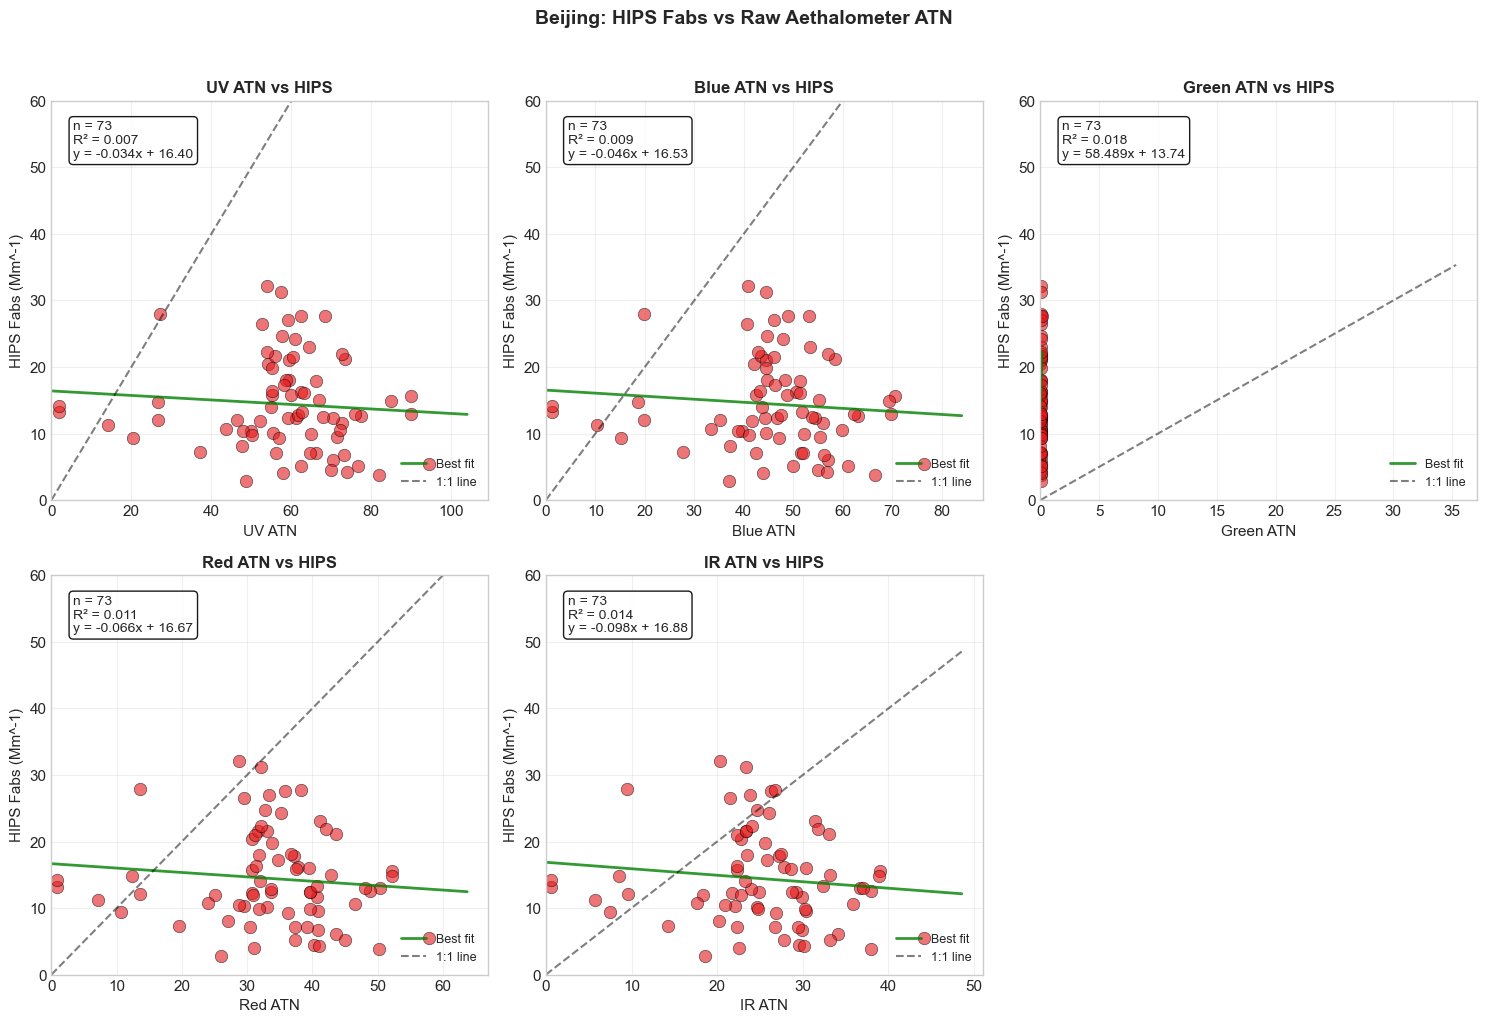


  Wavelength        n       R2      Slope
  ----------------------------------------
  UV               73    0.007     -0.034
  Blue             73    0.009     -0.046
  Green            73    0.018     58.489
  Red              73    0.011     -0.066
  IR               73    0.014     -0.098

Delhi: HIPS Fabs vs Aethalometer ATN


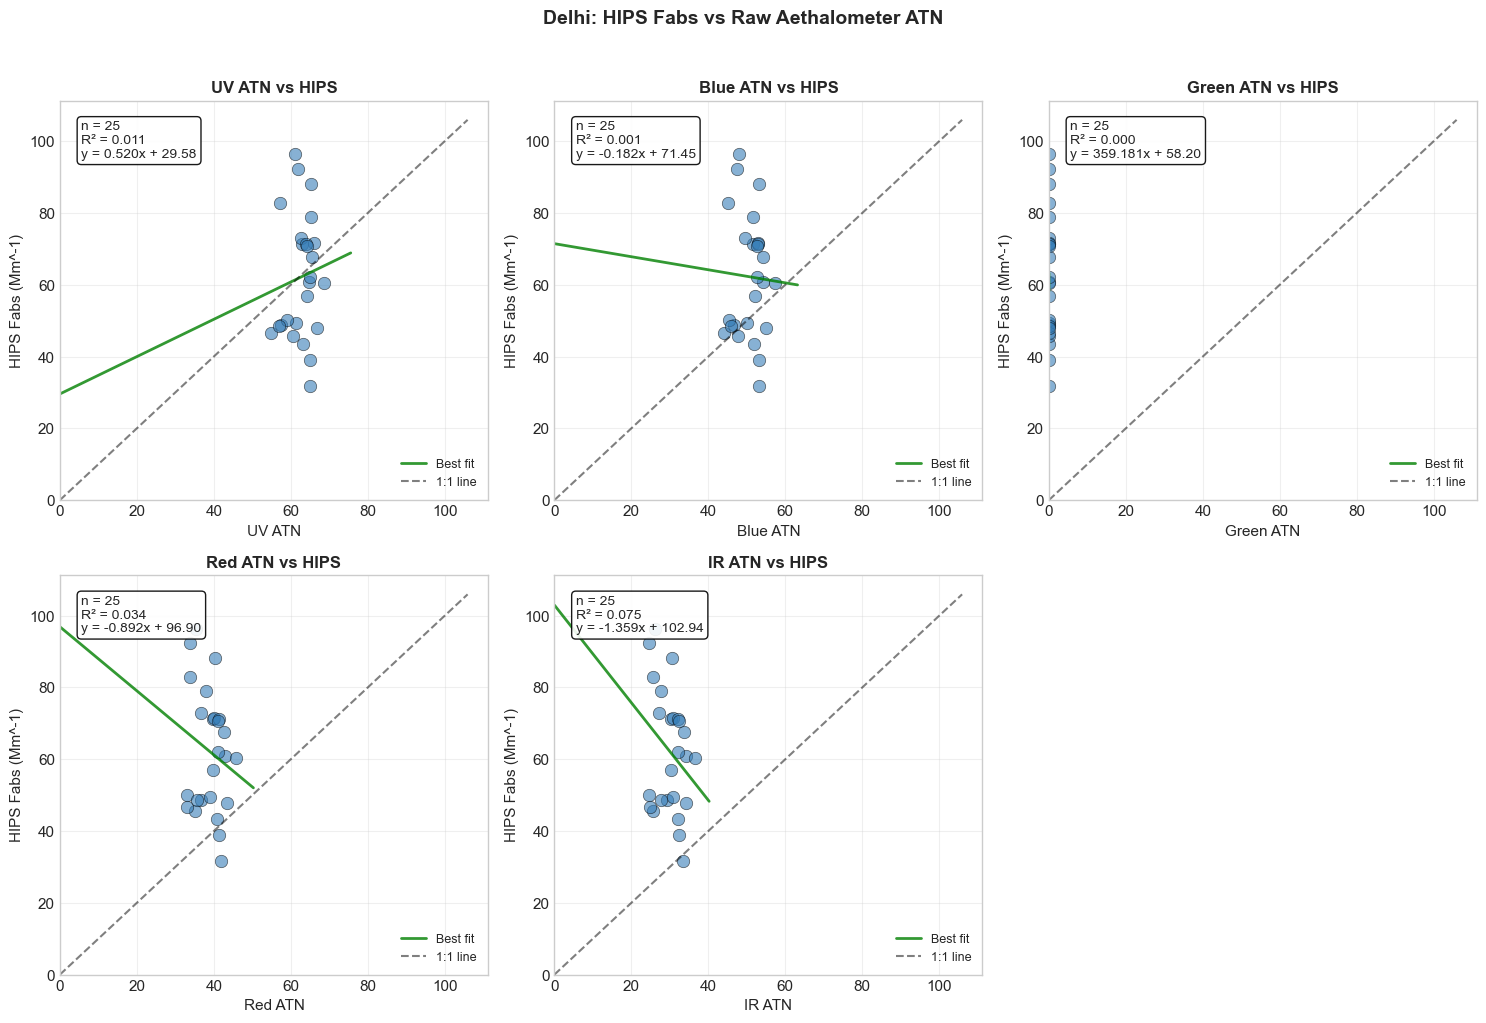


  Wavelength        n       R2      Slope
  ----------------------------------------
  UV               25    0.011      0.520
  Blue             25    0.001     -0.182
  Green            25    0.000    359.181
  Red              25    0.034     -0.892
  IR               25    0.075     -1.359

JPL: HIPS Fabs vs Aethalometer ATN


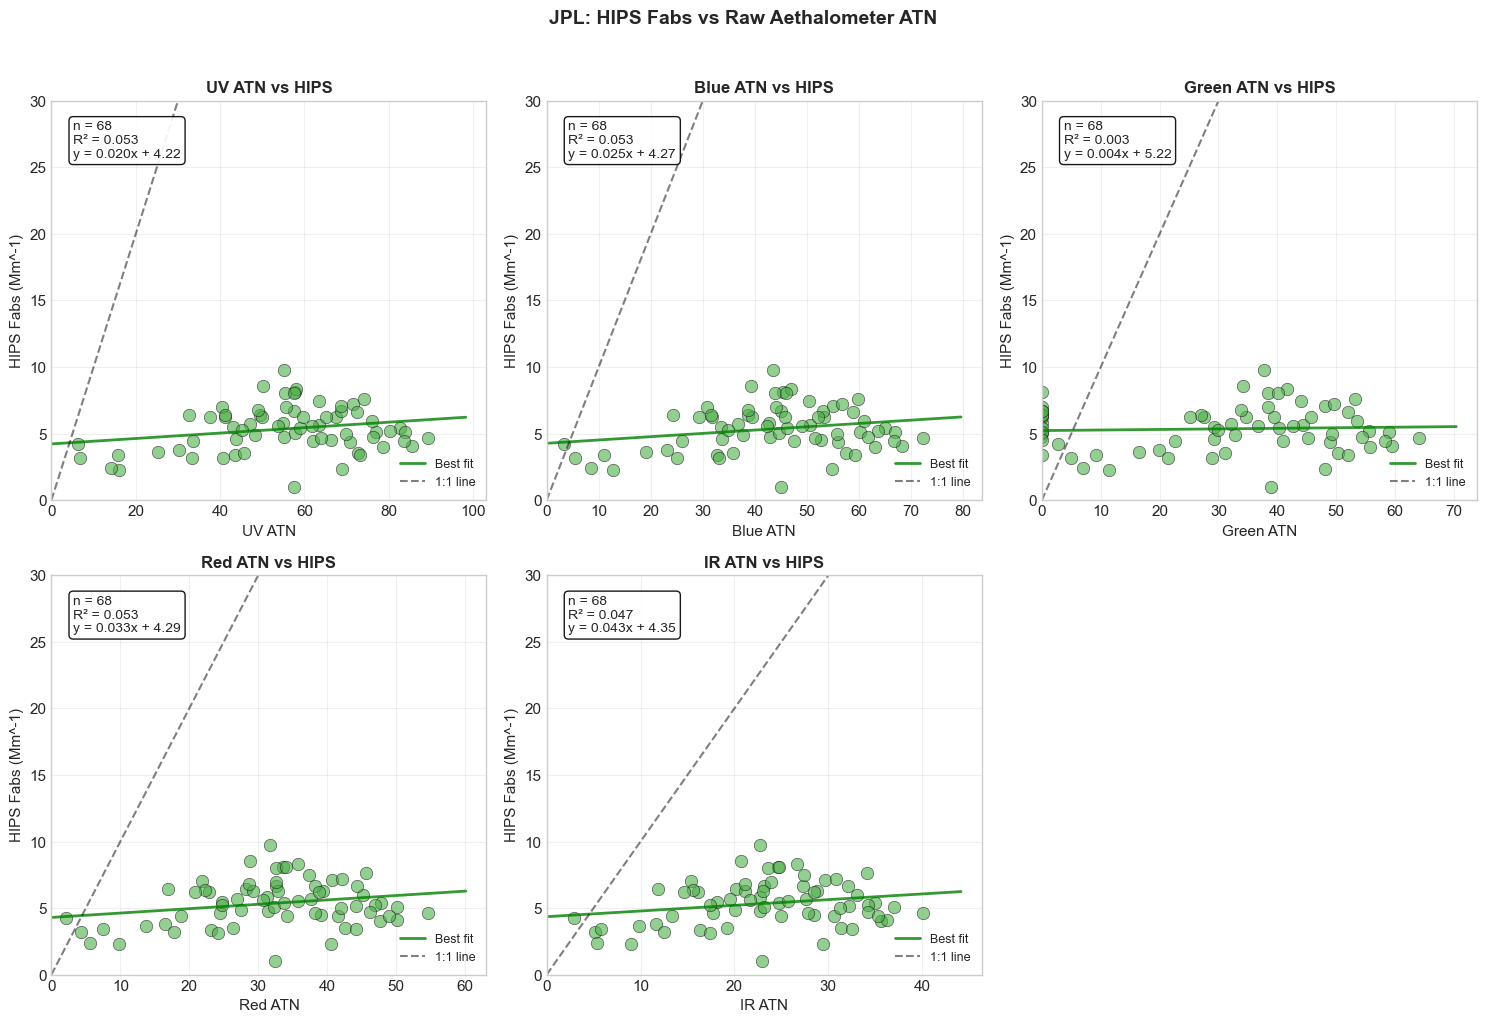


  Wavelength        n       R2      Slope
  ----------------------------------------
  UV               68    0.053      0.020
  Blue             68    0.053      0.025
  Green            68    0.003      0.004
  Red              68    0.053      0.033
  IR               68    0.047      0.043

Addis Ababa: HIPS Fabs vs Aethalometer ATN


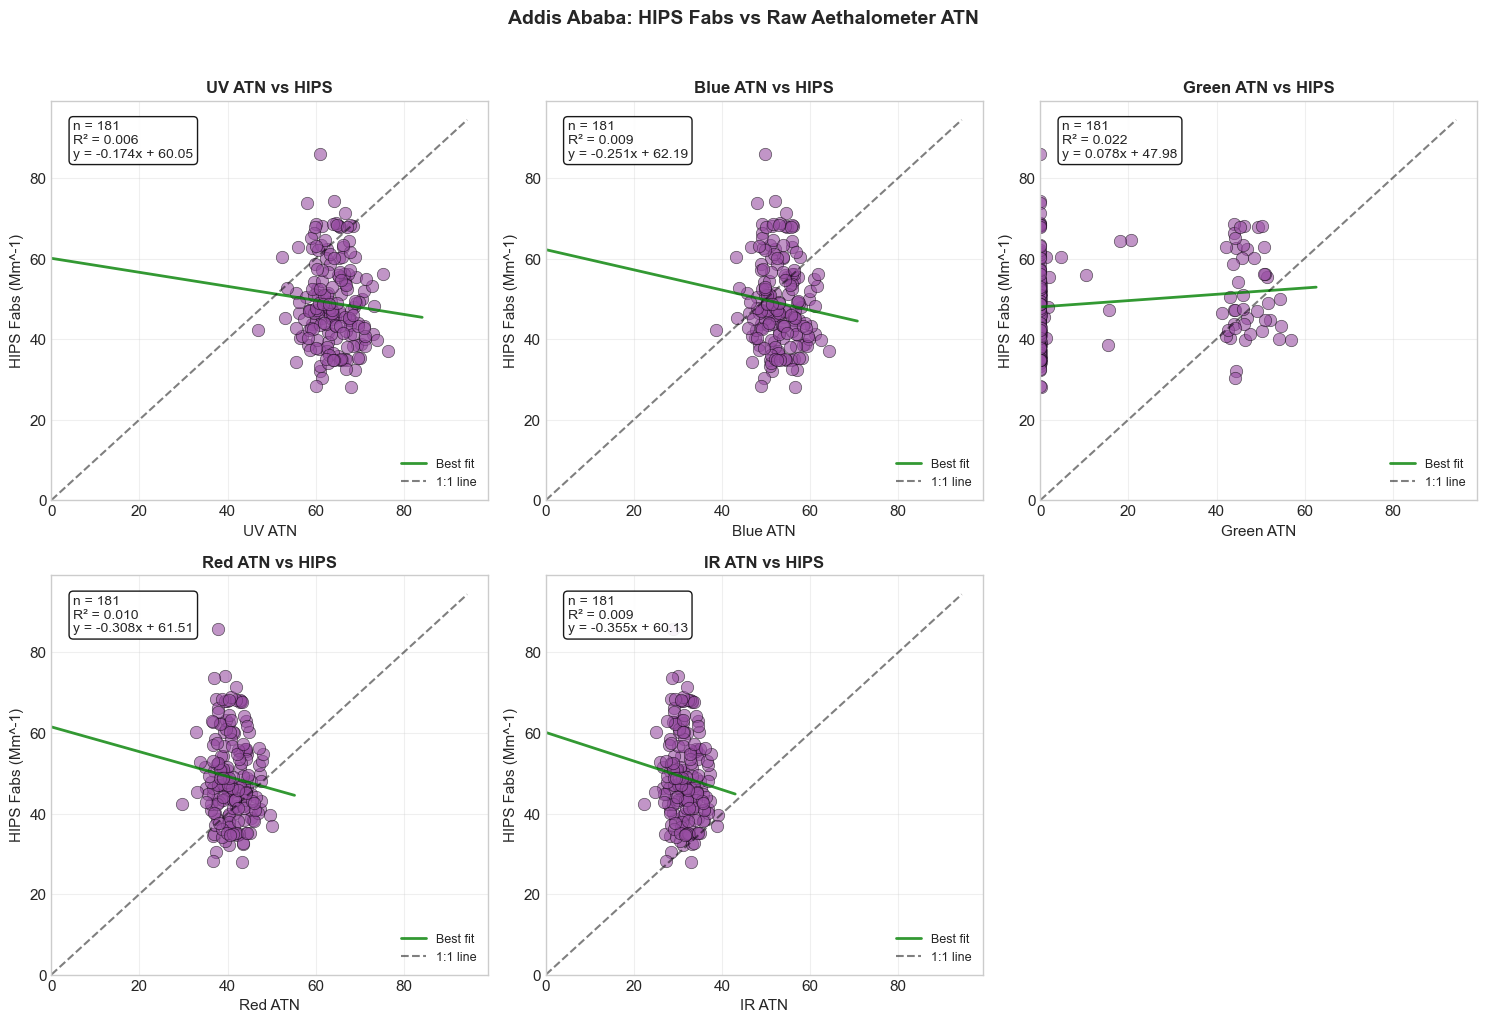


  Wavelength        n       R2      Slope
  ----------------------------------------
  UV              181    0.006     -0.174
  Blue            181    0.009     -0.251
  Green           181    0.022      0.078
  Red             181    0.010     -0.308
  IR              181    0.009     -0.355


In [53]:
# HIPS vs ATN comparison for each wavelength and site
atn_results = {}

# Site-specific y-axis limits for HIPS Fabs
SITE_YLIM = {
    'Beijing': 60,
    'JPL': 30,
    'Delhi': None,  # Auto
    'Addis Ababa': None  # Auto
}

for site_name, matched in matched_data.items():
    config = SITES[site_name]
    
    print(f"\n{'='*70}")
    print(f"{site_name}: HIPS Fabs vs Aethalometer ATN")
    print(f"{'='*70}")
    
    # Find ATN columns
    atn_cols = [c for c in matched.columns if 'ATN' in c]
    
    if len(atn_cols) == 0:
        print("  No ATN data available for this site.")
        continue
    
    # Create 2x3 grid layout (3 on top, 2 on bottom)
    n_wl = len(atn_cols)
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes_flat = axes.flatten()
    
    # Hide unused subplots
    for idx in range(n_wl, 6):
        axes_flat[idx].set_visible(False)
    
    site_results = {}
    y_max = SITE_YLIM.get(site_name)
    
    for idx, atn_col in enumerate(atn_cols):
        wl = atn_col.replace('_ATN', '')
        ax = axes_flat[idx]
        
        reg_stats = plot_comparison(
            ax,
            matched[atn_col].values,
            matched['hips_fabs'].values,
            f'{wl} ATN',
            'HIPS Fabs (Mm^-1)',
            config['color'],
            f'{wl} ATN vs HIPS'
        )
        
        # Set consistent y-axis limit if specified
        if y_max is not None:
            ax.set_ylim(0, y_max)
        
        if reg_stats:
            site_results[wl] = reg_stats
    
    plt.suptitle(f'{site_name}: HIPS Fabs vs Raw Aethalometer ATN', 
                 fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()
    
    atn_results[site_name] = site_results
    
    # Print summary
    if site_results:
        print(f"\n  {'Wavelength':<12s} {'n':>6s} {'R2':>8s} {'Slope':>10s}")
        print(f"  {'-'*40}")
        for wl, stats in site_results.items():
            print(f"  {wl:<12s} {stats['n']:>6d} {stats['r_squared']:>8.3f} {stats['slope']:>10.3f}")

## 7. Compare HIPS vs BCc (Processed)

Compare with the processed BC concentration to see if processing improves or degrades the correlation.


Beijing: HIPS (BC equiv) vs Aethalometer BCc


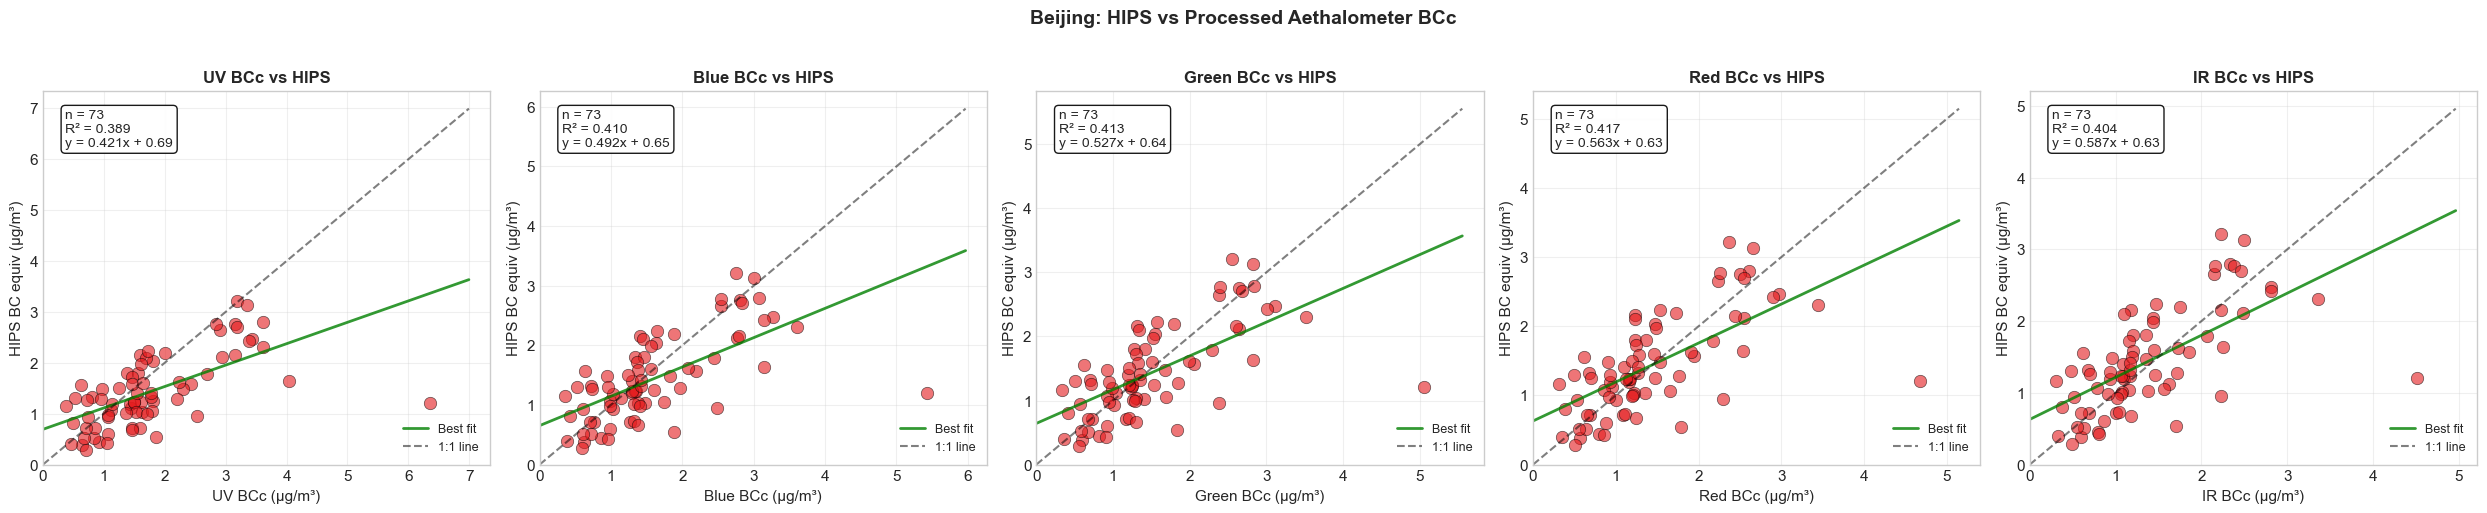


  Wavelength        n       R²      Slope
  ----------------------------------------
  UV               73    0.389      0.421
  Blue             73    0.410      0.492
  Green            73    0.413      0.527
  Red              73    0.417      0.563
  IR               73    0.404      0.587

Delhi: HIPS (BC equiv) vs Aethalometer BCc


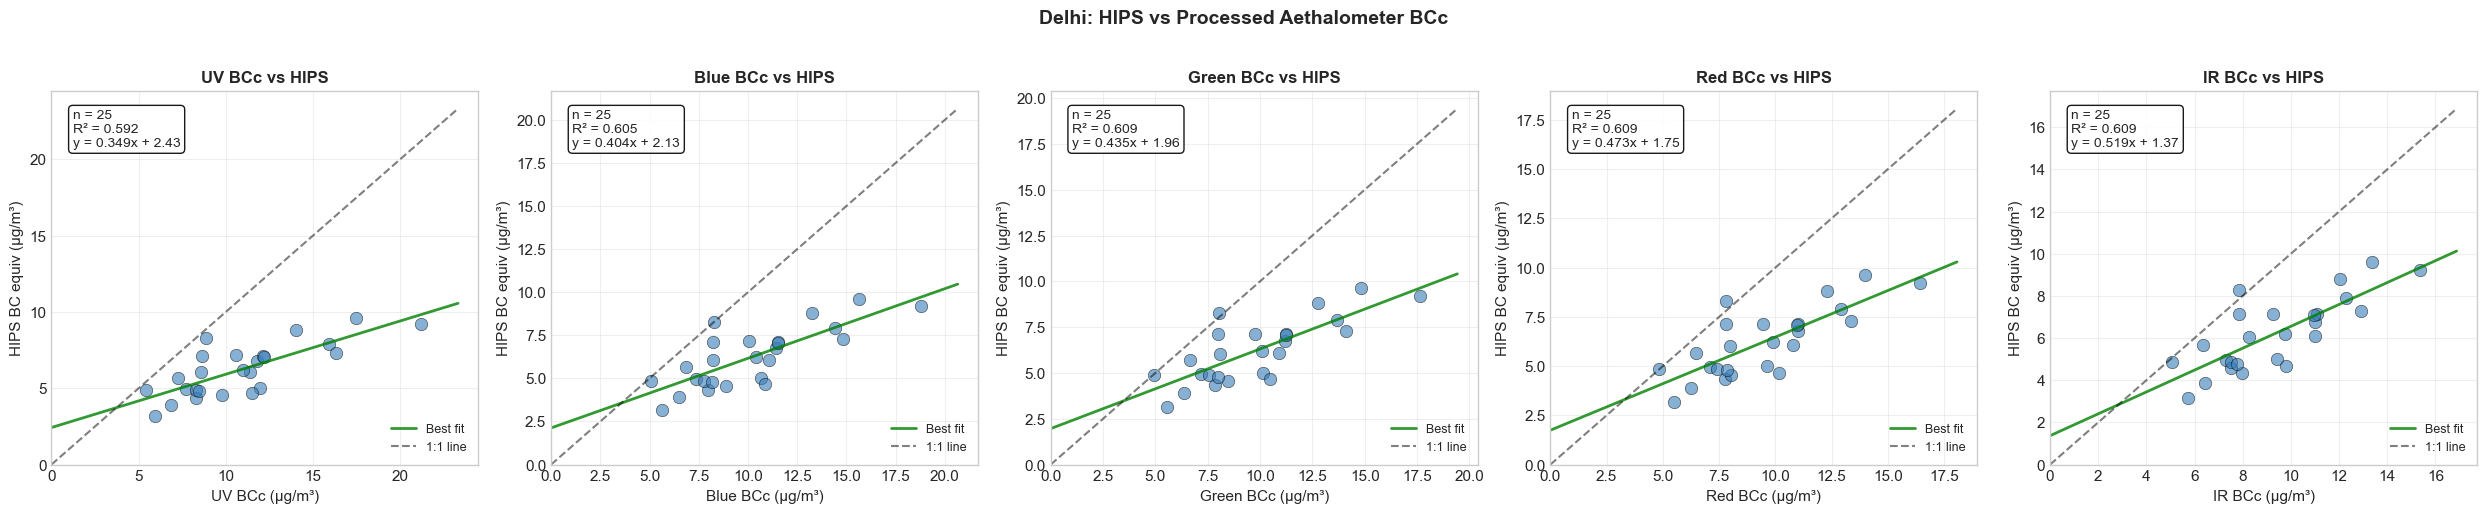


  Wavelength        n       R²      Slope
  ----------------------------------------
  UV               25    0.592      0.349
  Blue             25    0.605      0.404
  Green            25    0.609      0.435
  Red              25    0.609      0.473
  IR               25    0.609      0.519

JPL: HIPS (BC equiv) vs Aethalometer BCc


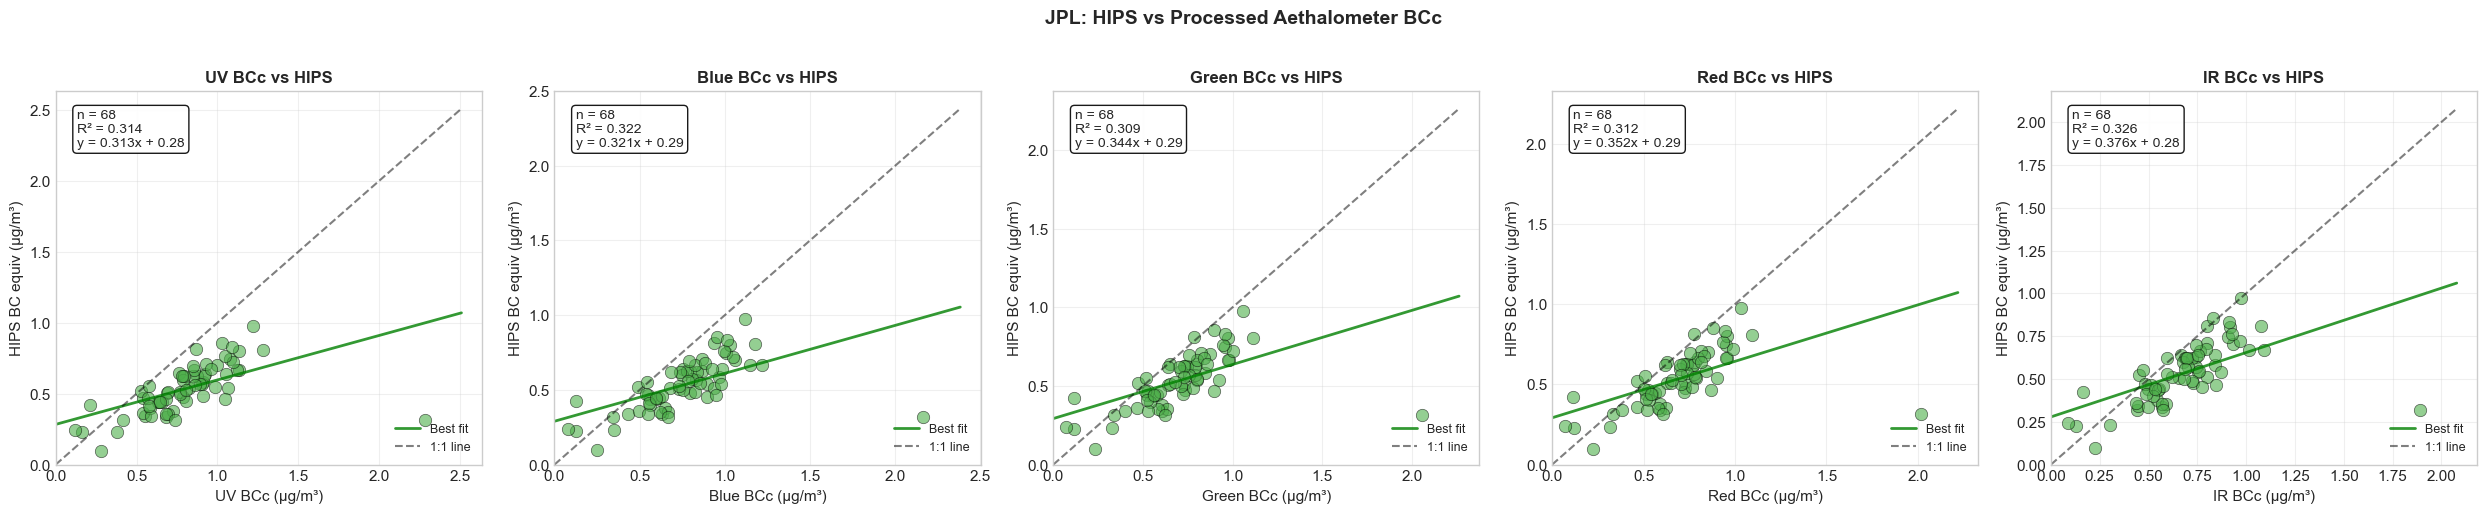


  Wavelength        n       R²      Slope
  ----------------------------------------
  UV               68    0.314      0.313
  Blue             68    0.322      0.321
  Green            68    0.309      0.344
  Red              68    0.312      0.352
  IR               68    0.326      0.376

Addis Ababa: HIPS (BC equiv) vs Aethalometer BCc


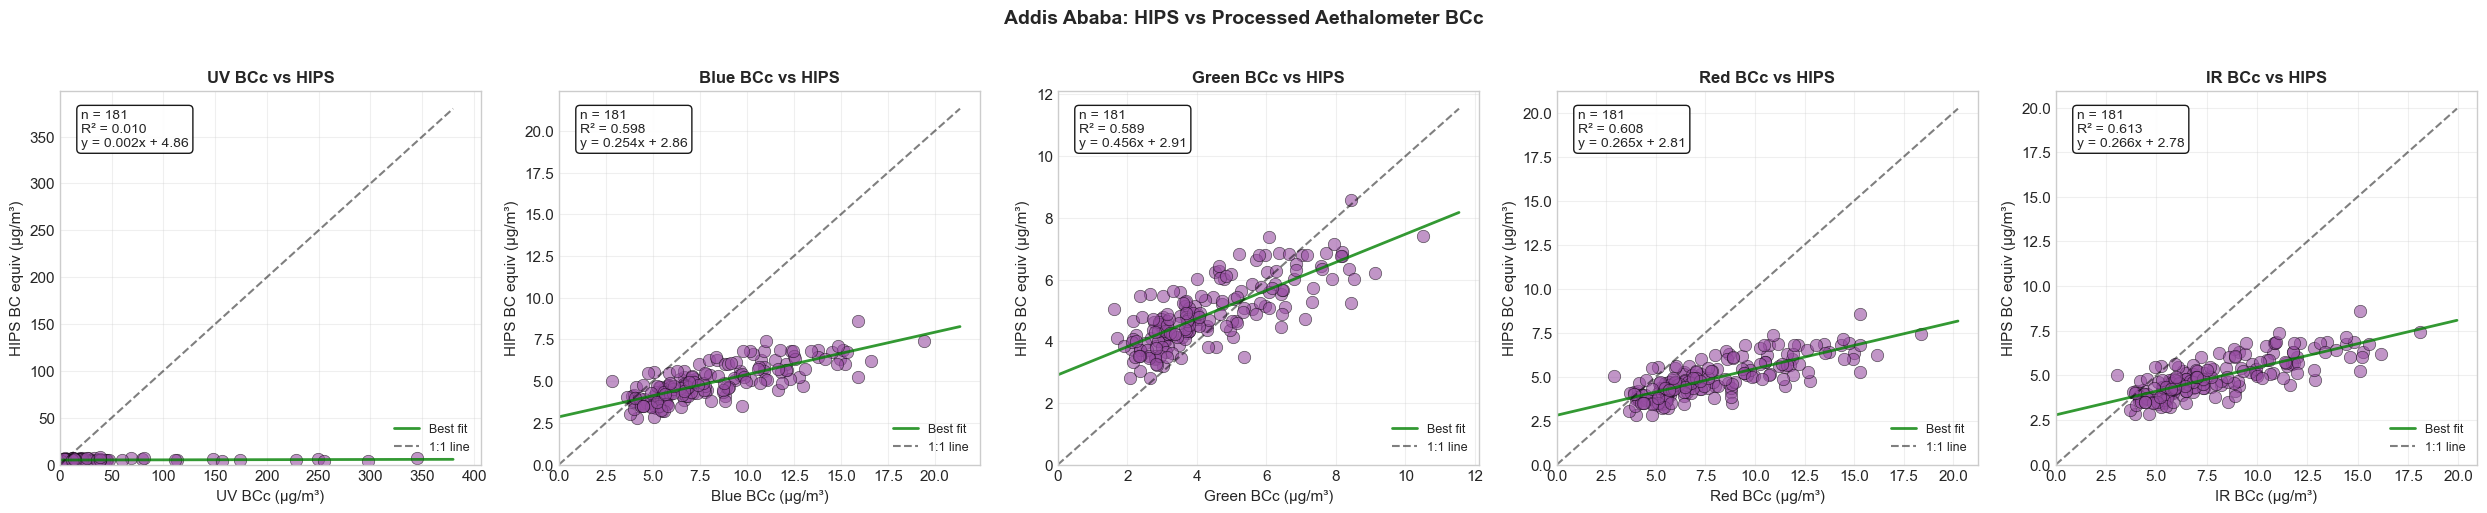


  Wavelength        n       R²      Slope
  ----------------------------------------
  UV              181    0.010      0.002
  Blue            181    0.598      0.254
  Green           181    0.589      0.456
  Red             181    0.608      0.265
  IR              181    0.613      0.266


In [54]:
# HIPS vs BCc comparison for each wavelength and site
bcc_results = {}

for site_name, matched in matched_data.items():
    config = SITES[site_name]
    
    print(f"\n{'='*70}")
    print(f"{site_name}: HIPS (BC equiv) vs Aethalometer BCc")
    print(f"{'='*70}")
    
    # Find BCc columns
    bcc_cols = [c for c in matched.columns if 'BCc' in c]
    
    if len(bcc_cols) == 0:
        print("  No BCc data available for this site.")
        continue
    
    # Create subplot for each wavelength
    n_wl = len(bcc_cols)
    fig, axes = plt.subplots(1, n_wl, figsize=(5*n_wl, 5))
    
    if n_wl == 1:
        axes = [axes]
    
    site_results = {}
    
    for idx, bcc_col in enumerate(bcc_cols):
        wl = bcc_col.replace('_BCc', '')
        
        # Use HIPS BC equivalent (same units as BCc: µg/m³)
        reg_stats = plot_comparison(
            axes[idx],
            matched[bcc_col].values,
            matched['hips_bc_equiv'].values,
            f'{wl} BCc (µg/m³)',
            'HIPS BC equiv (µg/m³)',
            config['color'],
            f'{wl} BCc vs HIPS'
        )
        
        if reg_stats:
            site_results[wl] = reg_stats
    
    plt.suptitle(f'{site_name}: HIPS vs Processed Aethalometer BCc', 
                 fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()
    
    bcc_results[site_name] = site_results
    
    # Print summary
    if site_results:
        print(f"\n  {'Wavelength':<12s} {'n':>6s} {'R²':>8s} {'Slope':>10s}")
        print(f"  {'-'*40}")
        for wl, stats in site_results.items():
            print(f"  {wl:<12s} {stats['n']:>6d} {stats['r_squared']:>8.3f} {stats['slope']:>10.3f}")

## 8. Direct Comparison: ATN vs BCc Correlations with HIPS

Which correlates better with HIPS - raw ATN or processed BCc?

In [55]:
# Compare ATN vs BCc correlations with HIPS
print("="*90)
print("COMPARISON: Does HIPS correlate better with raw ATN or processed BCc?")
print("="*90)
print("\nHigher R² = better correlation with HIPS")
print("If ATN R² > BCc R²: Processing may be degrading the optical signal")
print("If BCc R² > ATN R²: Processing improves accuracy")

comparison_data = []

for site_name in matched_data.keys():
    print(f"\n{'-'*70}")
    print(f"{site_name}")
    print(f"{'-'*70}")
    
    site_atn = atn_results.get(site_name, {})
    site_bcc = bcc_results.get(site_name, {})
    
    # Find common wavelengths
    common_wl = set(site_atn.keys()) & set(site_bcc.keys())
    
    if not common_wl:
        print("  No common wavelengths for comparison")
        continue
    
    print(f"\n  {'Wavelength':<12s} {'ATN R²':>10s} {'BCc R²':>10s} {'Difference':>12s} {'Better':>10s}")
    print(f"  {'-'*60}")
    
    for wl in sorted(common_wl):
        atn_r2 = site_atn[wl]['r_squared']
        bcc_r2 = site_bcc[wl]['r_squared']
        diff = bcc_r2 - atn_r2
        better = 'BCc' if diff > 0 else 'ATN'
        
        print(f"  {wl:<12s} {atn_r2:>10.3f} {bcc_r2:>10.3f} {diff:>+12.3f} {better:>10s}")
        
        comparison_data.append({
            'site': site_name,
            'wavelength': wl,
            'atn_r2': atn_r2,
            'bcc_r2': bcc_r2,
            'difference': diff,
            'better': better
        })

# Create comparison DataFrame
if comparison_data:
    comparison_df = pd.DataFrame(comparison_data)

COMPARISON: Does HIPS correlate better with raw ATN or processed BCc?

Higher R² = better correlation with HIPS
If ATN R² > BCc R²: Processing may be degrading the optical signal
If BCc R² > ATN R²: Processing improves accuracy

----------------------------------------------------------------------
Beijing
----------------------------------------------------------------------

  Wavelength       ATN R²     BCc R²   Difference     Better
  ------------------------------------------------------------
  Blue              0.009      0.410       +0.401        BCc
  Green             0.018      0.413       +0.395        BCc
  IR                0.014      0.404       +0.390        BCc
  Red               0.011      0.417       +0.406        BCc
  UV                0.007      0.389       +0.382        BCc

----------------------------------------------------------------------
Delhi
----------------------------------------------------------------------

  Wavelength       ATN R²     BCc R²   Di

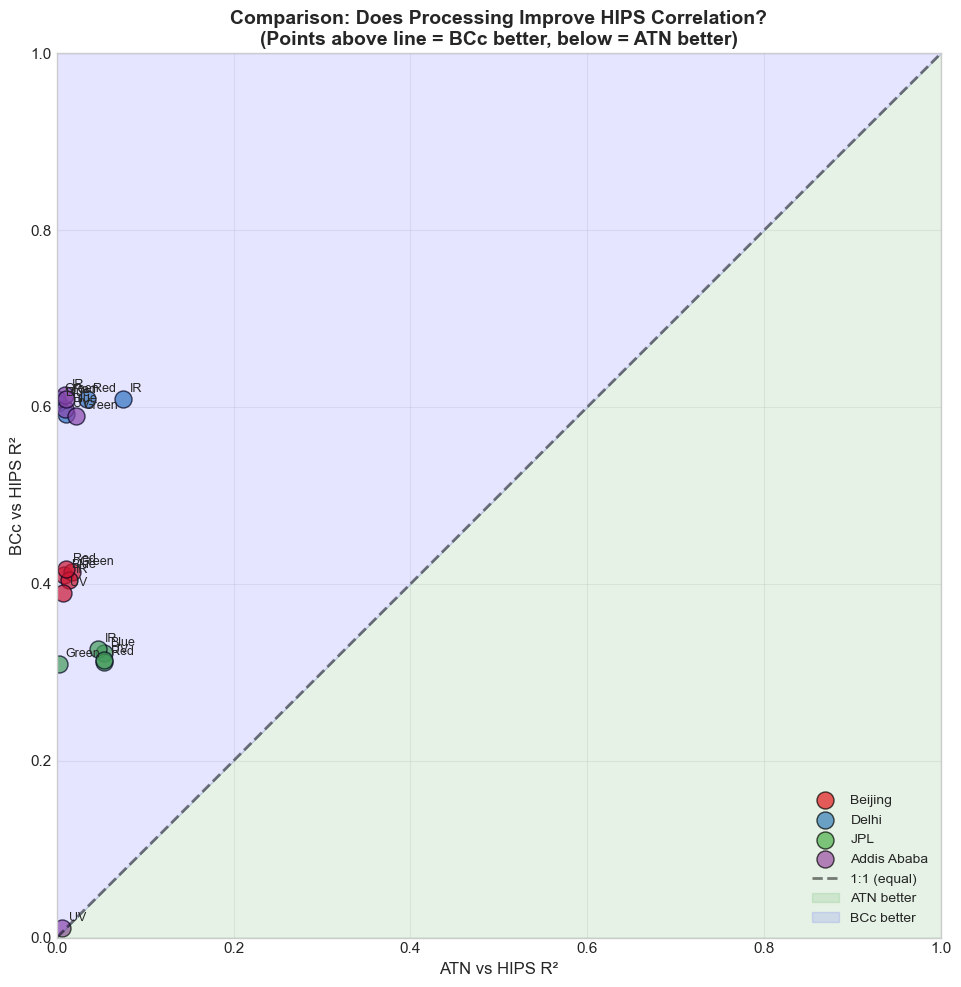


Overall Summary:
  Total comparisons: 20
  ATN better: 0 (0.0%)
  BCc better: 20 (100.0%)
  Mean R² difference (BCc - ATN): +0.431


In [56]:
# Visualization: ATN R² vs BCc R² scatter
if comparison_data:
    fig, ax = plt.subplots(figsize=(10, 10))
    
    for site_name in matched_data.keys():
        site_df = comparison_df[comparison_df['site'] == site_name]
        color = SITES[site_name]['color']
        
        ax.scatter(site_df['atn_r2'], site_df['bcc_r2'],
                   color=color, s=150, alpha=0.7,
                   edgecolors='black', linewidth=1,
                   label=site_name)
        
        # Add wavelength labels
        for _, row in site_df.iterrows():
            ax.annotate(row['wavelength'], 
                       (row['atn_r2'], row['bcc_r2']),
                       xytext=(5, 5), textcoords='offset points',
                       fontsize=9)
    
    # 1:1 line
    ax.plot([0, 1], [0, 1], 'k--', alpha=0.5, linewidth=2, label='1:1 (equal)')
    
    # Fill regions
    ax.fill_between([0, 1], [0, 0], [0, 1], alpha=0.1, color='green',
                    label='ATN better')
    ax.fill_between([0, 1], [0, 1], [1, 1], alpha=0.1, color='blue',
                    label='BCc better')
    
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_aspect('equal')
    ax.set_xlabel('ATN vs HIPS R²', fontsize=12)
    ax.set_ylabel('BCc vs HIPS R²', fontsize=12)
    ax.set_title('Comparison: Does Processing Improve HIPS Correlation?\n(Points above line = BCc better, below = ATN better)',
                 fontsize=14, fontweight='bold')
    ax.legend(loc='lower right', fontsize=10)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Summary statistics
    print("\nOverall Summary:")
    print(f"  Total comparisons: {len(comparison_df)}")
    print(f"  ATN better: {(comparison_df['better'] == 'ATN').sum()} ({100*(comparison_df['better'] == 'ATN').mean():.1f}%)")
    print(f"  BCc better: {(comparison_df['better'] == 'BCc').sum()} ({100*(comparison_df['better'] == 'BCc').mean():.1f}%)")
    print(f"  Mean R² difference (BCc - ATN): {comparison_df['difference'].mean():+.3f}")

## 9. Wavelength-Specific Analysis

HIPS uses ~405 nm. Which aethalometer wavelength (UV=375nm, Blue=470nm) correlates best?

In [57]:
# Find best matching wavelength for HIPS
print("="*80)
print("WAVELENGTH MATCHING ANALYSIS")
print("="*80)
print(f"\nHIPS wavelength: {HIPS_WAVELENGTH_NM} nm")
print("Aethalometer wavelengths: UV=375nm, Blue=470nm, Green=528nm, Red=625nm, IR=880nm")
print("\nExpected: UV (375nm) or Blue (470nm) should correlate best with HIPS (405nm)")

# Aggregate by wavelength across all sites
wl_summary = {}

for wl in WAVELENGTHS:
    bcc_r2_list = []
    atn_r2_list = []
    
    for site_name in matched_data.keys():
        if site_name in bcc_results and wl in bcc_results[site_name]:
            bcc_r2_list.append(bcc_results[site_name][wl]['r_squared'])
        if site_name in atn_results and wl in atn_results[site_name]:
            atn_r2_list.append(atn_results[site_name][wl]['r_squared'])
    
    if bcc_r2_list or atn_r2_list:
        wl_summary[wl] = {
            'bcc_mean_r2': np.mean(bcc_r2_list) if bcc_r2_list else np.nan,
            'atn_mean_r2': np.mean(atn_r2_list) if atn_r2_list else np.nan,
            'n_sites_bcc': len(bcc_r2_list),
            'n_sites_atn': len(atn_r2_list)
        }

print(f"\n{'Wavelength':<12s} {'ATN Mean R²':>14s} {'BCc Mean R²':>14s} {'n_sites':>10s}")
print("-"*55)

for wl, stats in wl_summary.items():
    atn_r2 = f"{stats['atn_mean_r2']:.3f}" if not np.isnan(stats['atn_mean_r2']) else 'N/A'
    bcc_r2 = f"{stats['bcc_mean_r2']:.3f}" if not np.isnan(stats['bcc_mean_r2']) else 'N/A'
    n_sites = max(stats['n_sites_atn'], stats['n_sites_bcc'])
    print(f"{wl:<12s} {atn_r2:>14s} {bcc_r2:>14s} {n_sites:>10d}")

# Find best wavelength
if wl_summary:
    best_bcc = max(wl_summary.items(), key=lambda x: x[1]['bcc_mean_r2'] if not np.isnan(x[1]['bcc_mean_r2']) else 0)
    print(f"\nBest BCc wavelength for HIPS correlation: {best_bcc[0]} (Mean R² = {best_bcc[1]['bcc_mean_r2']:.3f})")

WAVELENGTH MATCHING ANALYSIS

HIPS wavelength: 405 nm
Aethalometer wavelengths: UV=375nm, Blue=470nm, Green=528nm, Red=625nm, IR=880nm

Expected: UV (375nm) or Blue (470nm) should correlate best with HIPS (405nm)

Wavelength      ATN Mean R²    BCc Mean R²    n_sites
-------------------------------------------------------
UV                    0.019          0.327          4
Blue                  0.018          0.483          4
Green                 0.011          0.480          4
Red                   0.027          0.487          4
IR                    0.036          0.488          4

Best BCc wavelength for HIPS correlation: IR (Mean R² = 0.488)


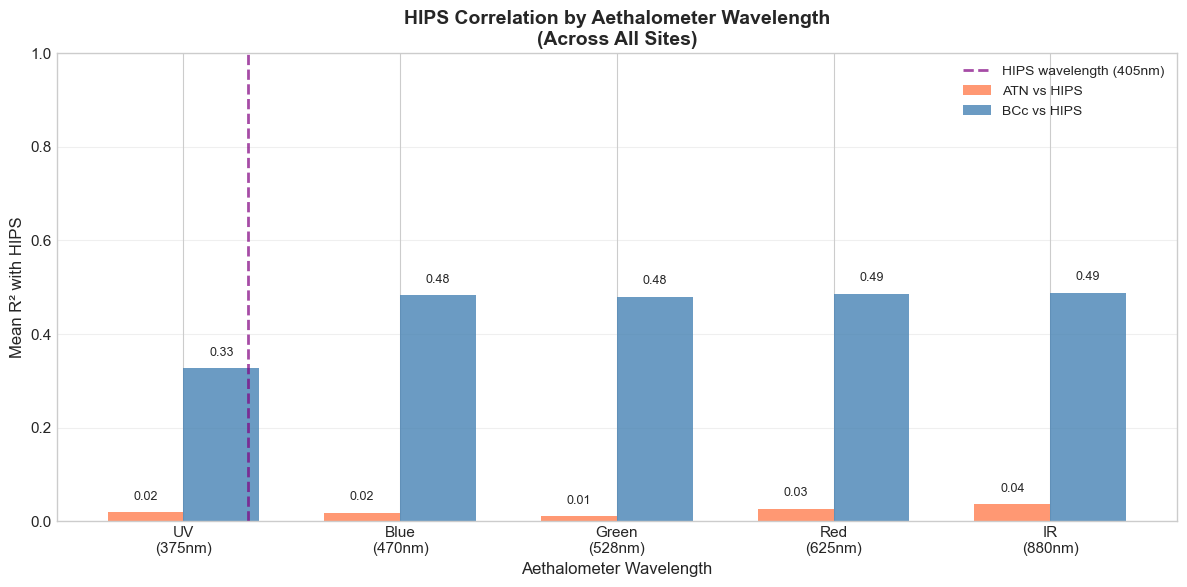

In [58]:
# Visualization: R² by wavelength
if wl_summary:
    fig, ax = plt.subplots(figsize=(12, 6))
    
    wavelengths_ordered = ['UV', 'Blue', 'Green', 'Red', 'IR']
    wavelengths_nm = [375, 470, 528, 625, 880]
    
    x_pos = np.arange(len(wavelengths_ordered))
    width = 0.35
    
    atn_vals = [wl_summary.get(wl, {}).get('atn_mean_r2', 0) for wl in wavelengths_ordered]
    bcc_vals = [wl_summary.get(wl, {}).get('bcc_mean_r2', 0) for wl in wavelengths_ordered]
    
    bars1 = ax.bar(x_pos - width/2, atn_vals, width, label='ATN vs HIPS', color='coral', alpha=0.8)
    bars2 = ax.bar(x_pos + width/2, bcc_vals, width, label='BCc vs HIPS', color='steelblue', alpha=0.8)
    
    # Mark HIPS wavelength
    ax.axvline(x=0.3, color='purple', linestyle='--', linewidth=2, alpha=0.7,
               label=f'HIPS wavelength ({HIPS_WAVELENGTH_NM}nm)')
    
    ax.set_xlabel('Aethalometer Wavelength', fontsize=12)
    ax.set_ylabel('Mean R² with HIPS', fontsize=12)
    ax.set_title('HIPS Correlation by Aethalometer Wavelength\n(Across All Sites)', 
                 fontsize=14, fontweight='bold')
    ax.set_xticks(x_pos)
    ax.set_xticklabels([f'{wl}\n({nm}nm)' for wl, nm in zip(wavelengths_ordered, wavelengths_nm)])
    ax.set_ylim(0, 1)
    ax.legend(loc='upper right', fontsize=10)
    ax.grid(True, alpha=0.3, axis='y')
    
    # Add value labels on bars
    for bar, val in zip(bars1, atn_vals):
        if val > 0:
            ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
                   f'{val:.2f}', ha='center', va='bottom', fontsize=9)
    for bar, val in zip(bars2, bcc_vals):
        if val > 0:
            ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
                   f'{val:.2f}', ha='center', va='bottom', fontsize=9)
    
    plt.tight_layout()
    plt.show()

## 10. Summary and Conclusions

In [59]:
print("="*90)
print("SUMMARY: HIPS vs AETHALOMETER OPTICAL COMPARISON")
print("="*90)

print("\n1. DATA AVAILABILITY")
print("-"*50)
for site_name, matched in matched_data.items():
    atn_avail = 'Yes' if any('ATN' in c for c in matched.columns) else 'No'
    bcc_avail = 'Yes' if any('BCc' in c for c in matched.columns) else 'No'
    print(f"  {site_name}: {len(matched)} pairs, ATN={atn_avail}, BCc={bcc_avail}")

print("\n2. PROCESSING EFFECT (BCc vs ATN correlation with HIPS)")
print("-"*50)
if comparison_data:
    atn_better_pct = 100 * (comparison_df['better'] == 'ATN').mean()
    bcc_better_pct = 100 * (comparison_df['better'] == 'BCc').mean()
    mean_diff = comparison_df['difference'].mean()
    
    print(f"  ATN correlates better: {atn_better_pct:.0f}% of cases")
    print(f"  BCc correlates better: {bcc_better_pct:.0f}% of cases")
    print(f"  Mean R² difference (BCc - ATN): {mean_diff:+.3f}")
    
    if mean_diff > 0.02:
        print("  → Processing IMPROVES correlation with HIPS")
    elif mean_diff < -0.02:
        print("  → Processing DEGRADES correlation with HIPS (raw ATN is better)")
    else:
        print("  → Processing has minimal effect on HIPS correlation")

print("\n3. WAVELENGTH MATCHING")
print("-"*50)
print(f"  HIPS wavelength: {HIPS_WAVELENGTH_NM} nm")
if wl_summary:
    best_wl = max(wl_summary.items(), 
                  key=lambda x: max(x[1]['bcc_mean_r2'] if not np.isnan(x[1]['bcc_mean_r2']) else 0,
                                   x[1]['atn_mean_r2'] if not np.isnan(x[1]['atn_mean_r2']) else 0))
    print(f"  Best matching wavelength: {best_wl[0]}")
    
print("\n4. INTERPRETATION")
print("-"*50)
print("""
  • If ATN correlates better with HIPS:
    - The aethalometer processing algorithms may introduce artifacts
    - Raw optical measurements are more directly comparable
    
  • If BCc correlates better with HIPS:
    - Processing successfully removes noise and artifacts
    - Dual-spot compensation improves accuracy
    
  • UV/Blue wavelengths should correlate best with HIPS (405nm)
    - If IR correlates best, this suggests wavelength-independent absorption
""")

SUMMARY: HIPS vs AETHALOMETER OPTICAL COMPARISON

1. DATA AVAILABILITY
--------------------------------------------------
  Beijing: 156 pairs, ATN=Yes, BCc=Yes
  Delhi: 63 pairs, ATN=Yes, BCc=Yes
  JPL: 130 pairs, ATN=Yes, BCc=Yes
  Addis Ababa: 181 pairs, ATN=Yes, BCc=Yes

2. PROCESSING EFFECT (BCc vs ATN correlation with HIPS)
--------------------------------------------------
  ATN correlates better: 0% of cases
  BCc correlates better: 100% of cases
  Mean R² difference (BCc - ATN): +0.431
  → Processing IMPROVES correlation with HIPS

3. WAVELENGTH MATCHING
--------------------------------------------------
  HIPS wavelength: 405 nm
  Best matching wavelength: IR

4. INTERPRETATION
--------------------------------------------------

  • If ATN correlates better with HIPS:
    - The aethalometer processing algorithms may introduce artifacts
    - Raw optical measurements are more directly comparable
    
  • If BCc correlates better with HIPS:
    - Processing successfully removes

In [60]:
print("\nAnalysis complete!")
print("\nNext steps:")
print("1. Investigate any site-specific differences")
print("2. Check if HIPS-aethalometer agreement varies with concentration level")
print("3. Look at time series to identify periods of poor agreement")
print("4. Consider MAC value sensitivity analysis")


Analysis complete!

Next steps:
1. Investigate any site-specific differences
2. Check if HIPS-aethalometer agreement varies with concentration level
3. Look at time series to identify periods of poor agreement
4. Consider MAC value sensitivity analysis
